## Imports

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from utilities import *
from scipy.ndimage.filters import gaussian_filter
from tqdm import tqdm
import os

## How can we determine if an image is forged?

We have just seen that the patchmatch algorithm succesfully identifies forged images in a restricted context. In particular, it performs poorly when the patches are resized with a large factor, and it is unable to detect inserted patches from other images. We wanted to extend this method to deal with these two situations.

Instinctively, forged images shouldn't be *consistent*: the modified regions should differ in some ways from the unmodified ones. One can thus be tempted to leverage the local parameters of an image (value, contrast, sharpness, white-balance...) to spot inconsistencies. However those vary drastically, even inside genuine natural images:

<!-- <img src="example_images/sq_an.jpg" alt="drawing" width="400"/>
<img src="example_images/bike_an.jpg" alt="drawing" width="400"/>
<img src="example_images/chic_an.jpg" alt="drawing" width="400"/>
<img src="example_images/int_an.jpg" alt="drawing" width="400"/>


(source: Pixabay.fr) -->

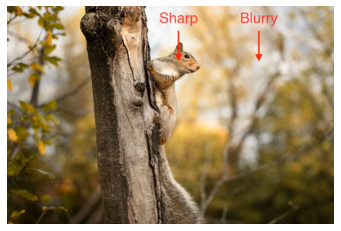

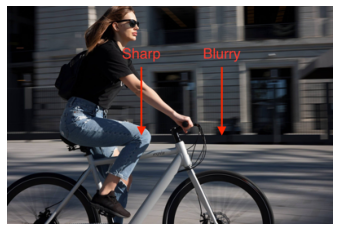

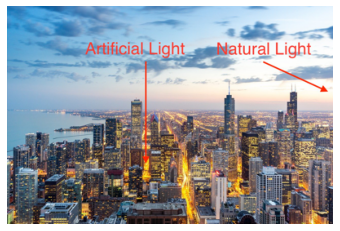

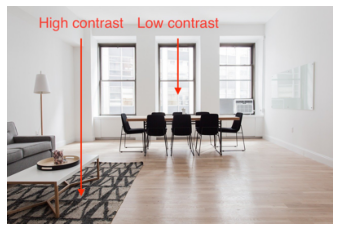

In [104]:
for f in ["example_images/sq_an.jpg", "example_images/bike_an.jpg", "example_images/chic_an.jpg", "example_images/int_an.jpg"]:
    im = Image.open(f); im.thumbnail((400,400)); plt.imshow(im);  plt.axis('off');plt.show()

(source: Pixabay.fr)

Lens blur and motion blur can lead to different sharpness levels, the existence of several light sources can modify the white balance locally, and even the contrast varies in the different regions of the image...  

Noise, however, almost only depends on the values of the photographed objects: it should be consistent across the whole image. The main difficulty is to separate it from the natural variations of the image: this is what we'll explore now.

## Naive try: a study of the local variance of a forged image

Let's have a look at the following forged image:

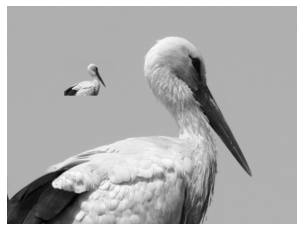

In [60]:
im = load_tensor_img("forged_images/cyg.png") ; plt.imshow(im, cmap='gray') ; plt.axis('off'); plt.show()

We can see that it contains a rescaled (rectangle) duplicate of itself. The sky region is smooth, so the rescaled portion should have less noise. 

Indeed, if $u(i)$ is a pixel of the sky (which is considered uniform of color $c \in [0,255]^3$), we have:
$$u(i,j) = c+\sigma n(i,j)  \text{, where } n(i,j )\sim \mathcal{N}(0,1)$$

If we resize the image by a factor 3, each pixel of the resized image will be an average of 9 pixels of the original image:
$$v(i,j) = \frac{1}{9} \sum_{ \substack{ i\leq k < i+3 \\ j\leq l < j+3}} u(k,l)$$

We thus have $\mathbb{E}(v) = \mathbb{E}(u) = c$ and  $\mathbb{V}(v) = \mathbb{V}(u)/9 = \sigma^2/9$. The new image can be expressed via:
$$v(i,j) = c+\frac{\sigma}{3} n'(i,j)  \text{, where } n'(i,j )\sim \mathcal{N}(0,1)$$


The noise should thus be reduced by a factor 3. Let's compute the standard deviation of 8x8 blocks to verify this:

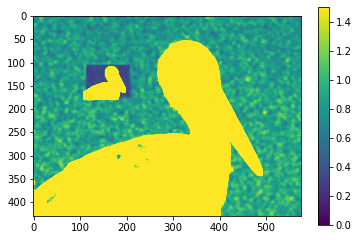

In [61]:
k=8 ; n,m = im.shape ; std = np.zeros((n-k,m-k))
for i in range(0,n-k):
    for j in range(0,m-k):
        std[i,j]=im[i:i+k,j:j+k].std()
plt.imshow(std, vmin=0, vmax=1.5) ; plt.colorbar() ;plt.show()

In [62]:
std[108:108+20, 117:117+20].mean()/std[:20, :20].mean()

0.35937798209915695

As expected, we observe a change of magnitude $\sim 3$ in the measured standard deviation. The same thing should happen when upscaling a portion of the image:

Let's consider an upscale of factor $2$ via a bilinear interpolation, and a $4 \times 4$ patch $(u(i,j), u(i+1,j), u(i,j+1), u(i+1,j+1))$ of the original image. It becomes a $16 \times 16$ patch with $4$ pixels corresponding to the same values, $8$ pixels average of two values, and $4$ pixels average of four values. 
The new variance is: 
$$\mathbb{V}(v) = \frac{4}{16}\mathbb{V}(u) + \frac{8}{16} \frac{1}{2}\mathbb{V}(u) + \frac{4}{16} \frac{1}{4}\mathbb{V}(u) = \frac{9}{16} \mathbb{V}(u)$$

If we have a patch upcaled by a factor 4, the variance is multiplied by $81/256$ and the standard deviation by a factor $9/16 = 0.5625$

Let's verify that with an almost invisible modification:

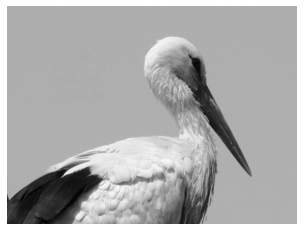

In [65]:
im = load_tensor_img("forged_images/cyg_up.png") ; plt.imshow(im, cmap='gray') ; plt.axis('off'); plt.show()

Computing the variance allows us to spot the forged region:

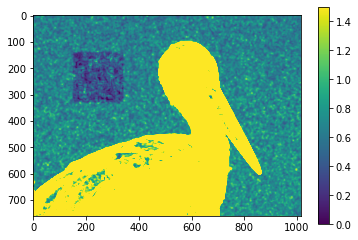

In [66]:
k=8 ; n,m = im.shape ; std = np.zeros((n-k,m-k))
for i in range(0,n-k):
    for j in range(0,m-k):
        std[i,j]=im[i:i+k,j:j+k].std()
plt.imshow(std, vmin=0, vmax=1.5) ; plt.colorbar() ;plt.show()

In [68]:
std[200:200+20, 200:200+20].mean()/std[:20, :20].mean()

0.6065028892758741

We have just seen that upscaling or downscaling patches in natural images changes the standard deviation of the noise. But a problem arises: even in the genuine regions of the images, the standard deviation can vary for different reasons (for instance, it is higher in the highly textured regions of the image). 

Thankfully, there exists a way to estimate noise (and not just variance): this is what we'll see in the next section.

## Image noise estimation 

In this section we implemented the following paper:

[*Analysis and Extension of the Ponomarenko et al. Method, Estimating a Noise Curve from a Single Image*, Miguel Colom, Antoni Buades (2013)](https://www.ipol.im/pub/art/2013/45/) [1]

It's based on a model in which the noise standard deviation $\sigma$ only depends on the value of the pixel. The idea is to compute the DCT decomposition of 8x8 patches, and use that to estimate noise: the first coefficients represent variations in the image (due to edges, corners, texture..), and the last ones account for noise.

The algorithm is the following:

- For mean intensity $c$ in a given range:
    - Select 8x8 blocks of mean intensity $c$
    - Compute their DCT decompositions
    - Sort them with respect to their first 16 coefficients
    - Select the first portion of size $f$
    - Estimate the noise with the larger coefficients
    
We implemented this algorithm in PyTorch.

### Image noise estimation: Pytorch noise estimation

Model DCT basis:


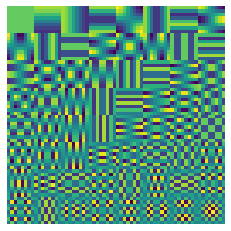

In [69]:
def dct_basis(n, k1, k2):
    x = np.array([range(n)])
    x = 2 * np.cos(np.pi * (2 * x + 1) * k1 / 2.0 / n)
    red1 = 1 / np.sqrt(2) if k1 == 0 else 1

    y = np.array([range(n)])
    y = 2 * np.cos(np.pi * (2 * y + 1) * k2 / 2.0 / n)
    red2 = 1 / np.sqrt(2) if k2 == 0 else 1

    return np.dot(x.T, y) * red1 * red2 / 2 / n


class DCT_CONV(nn.Module):
    def __init__(self, ksize=8, T=36):
        """ k: kernel size
            T: number of first coefficients used"""
        super(__class__, self).__init__()

        dtype = torch.FloatTensor
        if torch.cuda.is_available():
            dtype = torch.cuda.FloatTensor
        self.ksize = ksize
        ch = ksize ** 2

        self.T = T

        self.padding = nn.ReflectionPad2d(2 * ksize // 2 - 1)

        self.conv_dct = nn.Conv2d(
            in_channels=1,
            out_channels=ch,
            kernel_size=ksize,
            stride=1,
            padding=0,
            bias=False,
        )

        indices = [(i % ksize, i // ksize) for i in range(ch)]
        indices.sort(key=lambda e: e[0] + e[1])
        for ind, i in zip(indices, range(ch)):
            a1 = dct_basis(ksize, ind[0], ind[1])
            self.conv_dct.weight.data[i, 0, :, :] = nn.Parameter(dtype(a1))

    def forward(self, x):
        """ input: H x W  image
            output: k^2 x H x W dct coefficients"""
        out = self.conv_dct(self.padding(x[None, None, :, :]))
        return out[0]

    def mean_dct(self, output):
        """mean of the smoothed output (kxk filter)"""
        return output[0, :, :] / self.ksize

    def lowfreq_var(self, output):
        """low_frequency variance, first T coefficients"""
        low_freq = output[1 : self.T, :, :] ** 2  # exclude mean
        low_freq = torch.sum(low_freq, dim=0) / (self.T - 1)
        return low_freq

    def highfreq_var(self, output):
        """low_frequency variance, first T coefficients"""
        low_freq = output[self.T :, :, :] ** 2  # exclude mean
        low_freq = torch.sum(low_freq, dim=0) / (self.ksize ** 2 - self.T)
        return low_freq

    def noise_var(
        self, output, mean_dct, lowfreq_var, low_val, high_val, f_var=0.01, median=True
    ):
        """returns relevant noise variance when image value is between low_val and high_val
            f_var: fractions used to estimate noise"""
        # select image values between low_val and high_val
        mean_mask = (mean_dct < high_val) * (mean_dct >= low_val)

        # Select small low_frequency variances (~uniform patches)
        lowf_variances = torch.masked_select(lowfreq_var, mean_mask)
        if lowf_variances.size()[0] == 0:
            return None
        tresh = torch.quantile(lowf_variances, f_var)
        lowf_mask = (lowfreq_var < tresh) * mean_mask

        # mask the corresponding pixels
        high_freq = (output[self.T :] * lowf_mask) ** 2
        high_freq = torch.sum(high_freq, dim=(1, 2)) / torch.sum(
            lowf_mask
        )  # mean of the variances [ksize**2 - T] vector
        if median:
            return torch.median(high_freq)
        return high_freq

    def image_variance_hist(self, x, e_per_bin=40000, f_var=0.01):
        """ input: [H,W] tensor
            output: variance histogram"""

        # compute DCT transforms, dim [ksize**2, H, W]
        output = self.forward(x)

        # compute image mean values
        mean_dct = self.mean_dct(output)  # dim [H, W]
        mean_list = mean_dct.flatten().sort()[0]

        # compute lowfreq_var
        lowfreq_var = self.lowfreq_var(output)  # dim [H, W]

        Lmeans = []
        Lvars = []
        if e_per_bin < len(mean_list):
            for index in range(0, len(mean_list), e_per_bin):
                low_val = mean_list[index]
                high_val = mean_list[min(index + e_per_bin, len(mean_list) - 1)]
                this_var = self.noise_var(
                    output, mean_dct, lowfreq_var, low_val, high_val, f_var
                )
                if not (this_var is None):
                    Lmeans.append((high_val + low_val).item() / 2)
                    Lvars.append(this_var.item())
        return Lmeans, Lvars

    def show_net(self):
        out_img = np.zeros((self.ksize ** 2, self.ksize ** 2))
        for i in range(self.ksize ** 2):
            x = i // self.ksize
            y = i % self.ksize
            out_img[
                x * self.ksize : (x + 1) * self.ksize,
                y * self.ksize : (y + 1) * self.ksize,
            ] = self.conv_dct.weight.data[i, 0, :, :]
        plt.imshow(out_img)
        plt.axis("off")
        plt.show()
        
M = DCT_CONV(ksize=8)
print("Model DCT basis:")
M.show_net()

### Image noise estimation: Noise curve extraction

Here is the low-frequency variance:

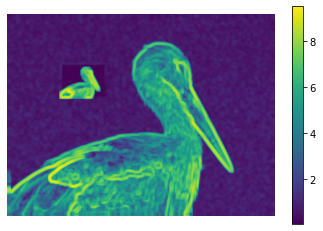

In [72]:
im = load_tensor_img("forged_images/cyg.png")
out = M.lowfreq_var(M(im))
plt.imshow(np.log(1+out.detach().numpy())); plt.axis('off'); plt.colorbar(); plt.show()

And the high-frequency variance:

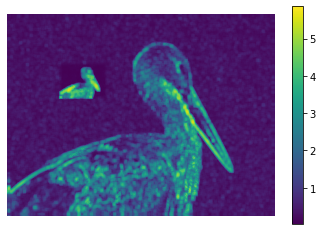

In [73]:
out = M.highfreq_var(M(im))
plt.imshow(np.log(1+out.detach().numpy())); plt.axis('off'); plt.colorbar(); plt.show()

By combining these two informations, we can estimate a noise curve:

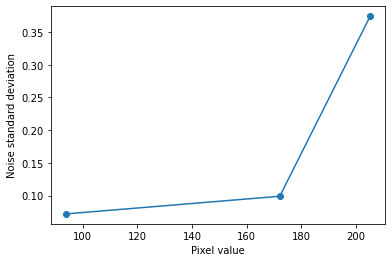

In [74]:
Lm,Lv= M.image_variance_hist(im, e_per_bin=100000, f_var=0.005)
plt.plot(Lm,Lv,'o-'); plt.xlabel("Pixel value"); plt.ylabel("Noise standard deviation"); plt.show()

Note that the noise is only estimated for certain values which are frequent in the image (here the values are $95, 175, 210$). We can now look for inconsistencies in the noise of images.

## From noise estimation to forgery detection

In this section we took inspiration in the following paper:

[*Forgery Detection in Digital Images by Multi-Scale Noise Estimation*, Marina Gardella, Pablo Musé, Jean-Michel Morel and Miguel Colom (2021)](https://www.mdpi.com/2313-433X/7/7/119/htm) [2]

The idea is to compute the noise curve estimation of the whole image and of each 64x64 patch. If the noise curve of a patch is noticeably lower than the curve of the whole image, the patch is suspicious. 

The full algorithm is the following:

- Compute the image noise curve $L$
- Create local score array $local\_score$
- For each patch of size 8x8:
    - Compute the patch noise curve $L_p(i,j)$
    - Compute the curve score $local\_score(i,j) = sc(L,L_p(i,j))$
- Create output array $suspicious\_pixels$
- If there exists $(i_0,j_0)$ s.t. $sc(L,L_p(i_0,j_0)) > 0.1$:
    - Blur the local score with a gaussian kernel $blurred(i,j) = blur(local\_score)$ 
    - Let $m = max(blurred)$
    - Let $suspicious\_pixels(i,j) = \mathbb{1}_{blurred(i,j) > m*0.5}$
- return $suspicious\_pixels$


In the paper [2], the curve score represents the number of bins in which the noise of the patch is lower than the image noise. This works for high resolution images, but not for small images. We implemented a custom metric (called `curve_score` in *utilities.py*), which measures the relative intesity of the histogram curves: a score of $0.2$ means that the patch noise curve is $20\%$ lower than the full noise curve. We also found that using a gaussian kernel optimizes the $f1$ score of the detected forgery.


Let's compute the noise 'curve' of a forged patch (which is rather an estimate of the noise for several frequent values):

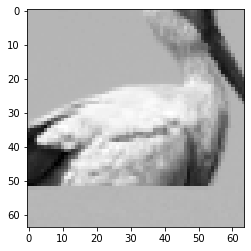

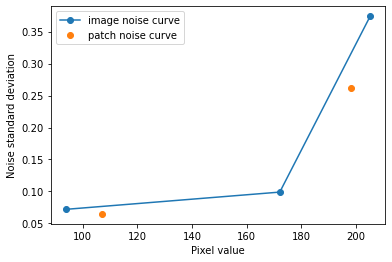

Patch score: 0.16882253051444274


In [86]:
im = load_tensor_img("forged_images/cyg.png")
patch = im[2*64:2*64+64, 2*64:2*64+64]; plt.imshow(patch, cmap='gray'); plt.show()
Lm2,Lv2= M.image_variance_hist(patch, e_per_bin=3000, f_var=0.1)
plt.plot(Lm,Lv,'o-', label="image noise curve" )
plt.plot(Lm2,Lv2,'o', label="patch noise curve"); plt.legend(); plt.xlabel("Pixel value"); plt.ylabel("Noise standard deviation"); plt.show()
print("Patch score:", curve_score(Lm,Lv,Lm2,Lv2))

Note that the orange dots are below the blue line: the noise is suspiciously low. We can now compute the score for each patch of the original image:

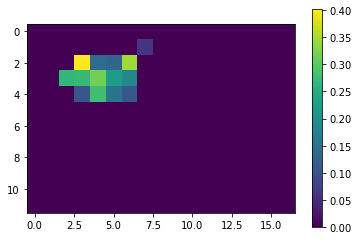

In [87]:
patch_size= 64; e_per_bin= 1500; f_var = 0.3
percent_wrong = compute_suspicious_pixels(M, im, patch_size, e_per_bin, f_var)
plt.imshow(percent_wrong); plt.colorbar(); plt.show()

If the image contains a patch of score > 0.1, we consider that it is forged. We blur the score image:

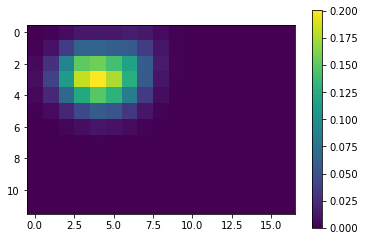

In [88]:
blured=gaussian_filter(percent_wrong, 1)
plt.imshow(blured); plt.colorbar(); plt.show()

And select the forged regions with a certain treshold:

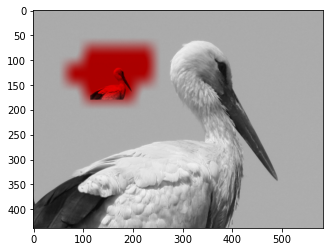

In [90]:
out_m = (blured>blured.max()*0.5)
plt.imshow(show_heat_map(im,out_m)); plt.show()

Success! The forged region has been identified in less than $3$ seconds. Let's try this on an another forged image, with a given modification mask:

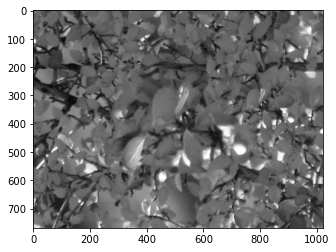

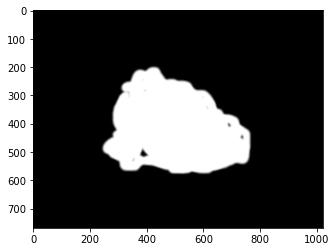

In [136]:
im = load_tensor_img("CMFDdb_grip/scale2/IMG_C01_006_2.0_copy.png")
mask = np.array(Image.open("CMFDdb_grip/scale2/IMG_C01_006_2.0_gt.png"))
plt.imshow(im, cmap='gray') ; plt.show() ;plt.imshow(mask, cmap='gray'); plt.show()

This is the result given by the original paper [2]:

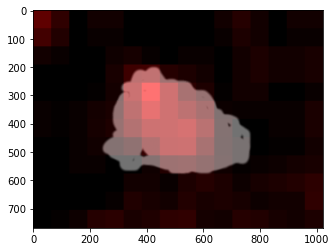

F-score: 0.5703201636556331


In [141]:
mask_morel = np.array(Image.open("MorelResult_resize/4.png"))/255.0
plt.imshow(show_heat_map(mask,mask_morel, "MASK")) ; plt.show()
print("F-score:", Fmeasure(mask, mask_morel))

This is ours:

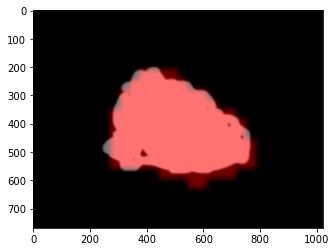

F-score: 0.9137122085291249


In [142]:
percent_wrong = compute_suspicious_pixels(M, im, patch_size, e_per_bin, f_var)
blured=gaussian_filter(percent_wrong, 1)
out_m = (blured>blured.max()*0.5)
plt.imshow(show_heat_map(mask,out_m, "MASK")) ; plt.show()
print("F-score:", Fmeasure(mask, out_m))

## Forgery detection on the benchmark dataset

In [ ]:
folder='scale1.5/'
files = os.listdir('CMFDdb_grip/'+folder)
files.sort()
def alexis_image(i):
    return 'CMFDdb_grip/'+folder+files[2*i]
def alexis_mask(i):
    return 'CMFDdb_grip/'+folder+files[2*i+1]

In [39]:
fms=[]
for k_im in tqdm(range(len(files)//2)):
    im = load_tensor_img(alexis_image(k_im))
    mask = np.array(Image.open(alexis_mask(k_im)))
    Lm,Lv= M.image_variance_hist(im, e_per_bin=100000, f_var=0.005)
    percent_wrong = compute_suspicious_pixels(M, im, 64, 1500, 0.3)

    # Gaussian filtering
    blured = gaussian_filter(percent_wrong, 1)
    if blured.max()>0.1:
        out_m = blured>blured.max()*0.5
    else:
        out_m = np.zeros_like(blured)

    fms.append(Fmeasure(mask,out_m)) 
sum(fms)/len(fms)

100%|██████████| 80/80 [06:29<00:00,  4.86s/it]


0.0015534305217469592

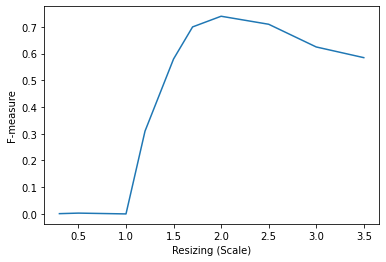

In [42]:
scales = [0.3, 0.5, 1, 1.2, 1.5, 1.7, 2, 2.5, 3, 3.5]
fmb=[0.001, 0.003,0.00,  0.31, 0.58, 0.70, 0.74, 0.71, 0.625, 0.585]

plt.plot(scales, fmb)
plt.xlabel('Resizing (Scale)')
plt.ylabel('F-measure')
plt.show()

We observe that this algorithm completes the patchmatch approach: it performs well with rescaled images. Interestingly, its performances decrease when the scale is too large. We believe it's because in this setting each resized patch almost covers the whole image, and thus hinders the noise estimation process. Unexpectedly, when the scale is inferior to $1$, almost no pixels are detected. We believe it's because the modified patches are too small and disappear in the smoothing step. 

## Conclusion

We have seen that the patchmatch algorithms shows good results on the dataset. It can be extented to better work on scaled patches with the method described in [2], which we extended with a new score (to better work on small images) and a blurring step (to optimize the $f1$ score). 

Image forgery can be done in various ways, and we only covered a portion of this vast subject. Our work could be further extended by an analysis of non organic additions in images.